In [1]:
#  Import Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [16]:
# Create Inspector and get details of table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
columns = inspector.get_columns("Station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [20]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [21]:
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

In [22]:
# Calculate the date one year from the last date in data set.
end_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = end_date - dt.timedelta(days=365)
print(start_date)


2016-08-23 00:00:00


In [87]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
end_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = end_date - dt.timedelta(days=365)
print(start_date)

# Perform a query to retrieve the data and precipitation scores
pr_data = [measurement.date,func.sum(measurement.prcp)]
precipitation = session.query(*pr_data).filter(func.strftime(measurement.date) >= start_date).\
                group_by(measurement.date).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['Measurement_Date', 'Precipitation_Amt'])
precipitation_df.dropna(axis=0, how='any', inplace=True)
precipitation_df.sort_values(by='Measurement_Date')
precipitation_df.set_index('Measurement_Date', inplace=True)



2016-08-23 00:00:00


In [89]:
#  View DataFrame
precipitation_df.head()

,Precipitation_Amt
Measurement_Date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


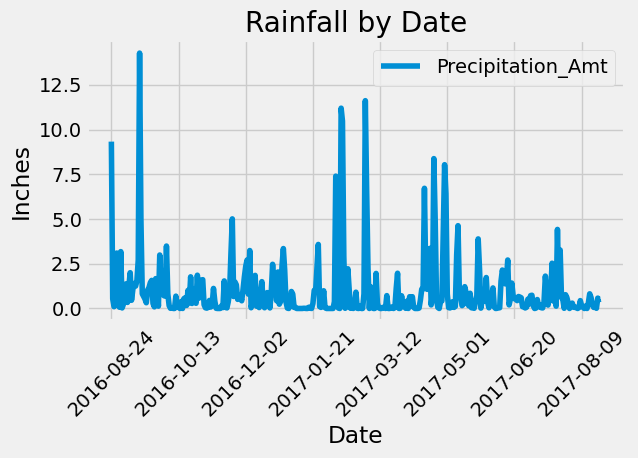

In [37]:
# Use Pandas Plotting with Matplotlib to plot the data
prchart = precipitation_df.plot(title="Rainfall by Date",xlabel="Date",ylabel="Inches",rot=45)
plt.tight_layout()
plt.show()

In [38]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation_Amt
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [59]:
# Design a query to calculate the total number of stations in the dataset
totalstations = session.query(func.count(station.station)).all()
print(totalstations)

[(1,)]


In [70]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activestations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).all()
station_list = []
for station in activestations:
    dict_stations = {
    "stations": station[0],
    "total": station[1]
    }
    station_list.append(dict_stations)
df = pd.DataFrame(station_list)
df2 = df.sort_values(["total"], ascending=False)
df2 = df2.reset_index()
df2

,index,stations,total
0,6,USC00519281,2772
1,7,USC00519397,2724
2,1,USC00513117,2709
3,8,USC00519523,2669
4,3,USC00516128,2612
5,2,USC00514830,2202
6,0,USC00511918,1979
7,4,USC00517948,1372
8,5,USC00518838,511


In [72]:
mostactivestation = df2.iloc[0,1]
mostactivestation

'USC00519281'

In [76]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = [measurement.station,
        func.min(measurement.tobs),
        func.max(measurement.tobs),
        func.avg(measurement.tobs)]
temp_sums = session.query(*temps).filter(measurement.station == "USC00519281").group_by(measurement.station)
for station in temp_sums:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


In [79]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station.

yearly_obs = (measurement.date, measurement.tobs)
yrly_temps = session.query(*yearly_obs).filter(func.strftime(measurement.date) >= start_date, measurement.station == "USC00519281").\
    group_by(measurement.date).order_by(measurement.date).all()
    
temps_df = pd.DataFrame(yrly_temps, columns=["Measurement Date", "Temperature"])
temps_df.head()


,Measurement Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


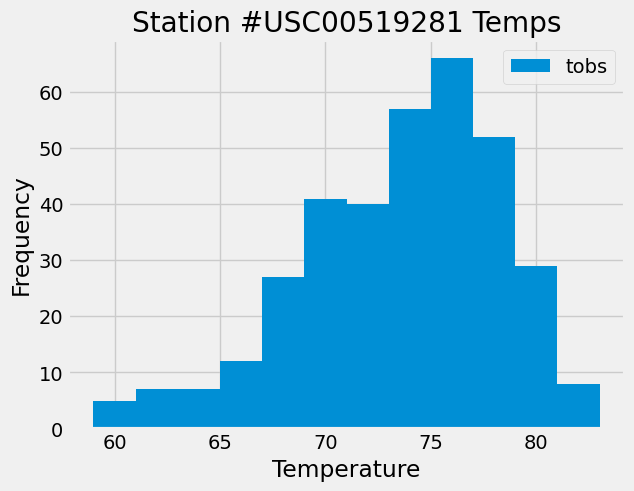

In [91]:
# Using the most active station id plot the results as a histogram

plt.hist(temps_df["Temperature"], bins=12, density=False, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Station #USC00519281 Temps")
plt.legend()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()